In [1]:
"""
Title: PixelCNN
Author: [ADMoreau](https://github.com/ADMoreau)
Date created: 2020/05/17
Last modified: 2020/05/23
Description: PixelCNN implemented in Keras.
"""

"""
## Introduction
PixelCNN is a generative model proposed in 2016 by van den Oord et al.
(reference: [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)).
It is designed to generate images (or other data types) iteratively
from an input vector where the probability distribution of prior elements dictates the
probability distribution of later elements. In the following example, images are generated
in this fashion, pixel-by-pixel, via a masked convolution kernel that only looks at data
from previously generated pixels (origin at the top left) to generate later pixels.
During inference, the output of the network is used as a probability ditribution
from which new pixel values are sampled to generate a new image
(here, with MNIST, the pixels values are either black or white).
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from keras.callbacks import History
import sfh
from sfh.model_utils import input_fn, predictor, pass_sample, finish_sample
history = History()
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
print(tfp.__version__)


%pylab inline

#  Important !!!! path to shared tensorflow dataset


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0
0.14.1
Populating the interactive namespace from numpy and matplotlib


In [34]:
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

In [4]:
import tensorflow_datasets as tfds
dset = tfds.load('sfh_interp', split='train', data_dir=data_dir)
sample = list(dset.take(5))[3]

num_components = 2
# Shape of the distribution
event_shape = [1]
# Utility function to compute how many parameters this distribution requires
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
print(params_size)

2021-12-09 18:04:56.617876: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


6


2021-12-09 18:04:57.479356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2021-12-09 18:04:57.830562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 18:04:57.882803: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
image_dset = tfds.load('tng100', split='train', data_dir=data_dir)
for example in image_dset.take(1):
    print(example.keys())

dict_keys(['Mstar', 'Mstar_Half', 'SFR_Max', 'SFR_Rad', 'SFR_halfRad', 'last_major_merger', 'last_over_max', 'mass_quantiles', 'noiseless_griz', 'object_id', 'sed', 'stellar_light', 'time', 'velocity_dispersion_map', 'velocity_map'])


In [7]:


def preprocessing(example):
    
    return tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1)), \
           tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1))

def input_fn(mode='train', batch_size=64, dataset_name='sfh', data_dir=None):
    """
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:80%]', data_dir=data_dir)
        #dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[80%:]', data_dir=data_dir)
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset, tf.data.experimental.cardinality(dset).numpy()

def predictor(model, sample_size, nsteps=100):
    res = np.zeros((sample_size, nsteps,1))
    for i in range(nsteps):
        tmp = model(res).sample()
        res[0,i] = tmp[0,i]
    return res

def pass_sample(model, sample, n_pass=100):
    sample = tf.reshape(sample,(1, 100, 1))
    mean = model(sample).mean()
    std = model(sample).stddev()
    p_sample = model(sample).sample()
    return mean, std, p_sample

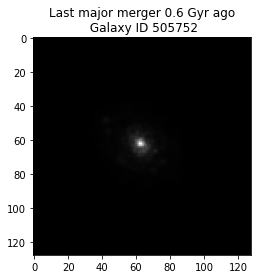

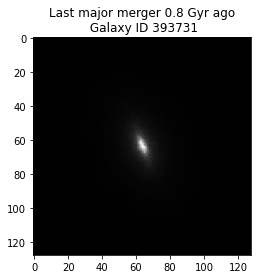

In [8]:
for example in image_dset.take(2):
    plt.figure()
    plt.imshow(example["noiseless_griz"][:,:,1],cmap='gray')
    lbt=float(example["last_major_merger"])
    plt.title("Last major merger "+str("{:.1f}".format(lbt))+" Gyr ago"+"\n Galaxy ID "+str(int(example["object_id"])))

In [8]:
from astropy.stats import mad_std

In [7]:
# Using a mapping function to apply preprocessing to our data
def evaluate_scaling(train_dset):
    """
    Evaluates the standard deviation of the pixel values in each band g,r,i,z.
    Input: train_dset (tensforflow dataset): training datset on which we want to evaluate the scaling
    Output: scaling (np array): array containig the std in each band
            mean (np array): array containig the mean in each band
    """
    #Takes 100 images from wich the std will be estimated  
    imgs=[]
    for (batch, entry) in enumerate(train_dset.take(100)):
        imgs.append(entry['noiseless_griz']) # was image
    imgs=np.array(imgs)
    #Computes the scaling
    mean=[]
    scaling = []
    maximum=[]
    for i,b in enumerate(['g', 'r', 'i', 'z']):
        sigma = mad_std(imgs[:,:,:,i].flatten())
        mean.append(np.mean(imgs[:,:,:,i].flatten()))
        scaling.append(sigma)
        maximum.append(np.max(imgs[:,:,:,i].flatten()))
    return scaling,mean,maximum



In [35]:


#scaling,mean,maximum=evaluate_scaling(train_dset) #noiseless_griz
scaling,mean,maximum=evaluate_scaling(image_dset)
print(scaling,mean,maximum)



[0.051026825001259345, 0.09456251587227937, 0.08115991621010538, 0.01630368388107681] [0.56321657, 1.0461978, 0.9236648, 0.19436844] [11090.467, 11711.27, 8269.19, 1504.0643]


In [38]:
def preprocessing(example):
    
    #img=example["noiseless_griz"] # was image
    #print("Before, type", type(img),img)
    ##norm_img=1/6*tf.math.asinh((img-mean)/tf.constant(scaling)*6)
    #norm_img=1/6*tf.math.asinh((img)/tf.constant(scaling)*6)
    
    #norm_img=img/tf.constant(maximum)
    ## Works better with maximum
    norm_img=1/6*tf.math.asinh((example["noiseless_griz"])/tf.constant(maximum)*6)
    
    sfr_max = tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(100,1))
    
    return (sfr_max, norm_img), sfr_max#tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1))

def image_input_pipeline(mode='train', batch_size=64, dataset_name='', data_dir=''):
    """
    Creates the input pipeline that loads the dataset and normalises the data
    Possible modes: 'train', 'valid' or 'test'.
    Input: mode (str): specifies the mode for train, validation or test
           batch_size (int): size of the batch
    Output= dataset (tf dataset): properly processes dataset
    """
    
    """
    mode: 'train' or 'test'
    """

    if mode == 'train':
        
        
        dataset = tfds.load('tng100', split='train[:80%]', data_dir=data_dir)
        dataset = dataset.map(preprocessing) # Apply data preprocessing
        
        dataset = dataset.shuffle(10000)
        
        #sfr_dataset = tfds.load(dataset_name, split='train[:80%]', data_dir=data_dir)
        
    elif mode=='valid':
        dataset = tfds.load('tng100', split='train[80%:]', data_dir=data_dir)
        dataset = dataset.map(preprocessing) # Apply data preprocessing        


    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
    return dataset

In [139]:
dataset_training=image_input_pipeline(mode='train', batch_size=32, data_dir=data_dir)
dataset_validation=image_input_pipeline(mode='valid', batch_size=32, data_dir=data_dir)


In [140]:
dataset_training.take(1)

<TakeDataset shapes: (((32, 100, 1), (32, 128, 128, 4)), (32, 100, 1)), types: ((tf.float32, tf.float32), tf.float32)>

In [179]:
importlib.reload(sfh)
pixel_cnn = sfh.models.pixelcnn_res.generate_model(kernel_size=2, optimizer=tf.keras.optimizers.Adam(0.0001))
pixel_cnn.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 masked_conv_layer_6 (MaskedCon  (None, 100, 16)     64          ['input_12[0][0]']               
 vLayer)                                                                                          
                                                                                                  
 conv1d_72 (Conv1D)             (None, 100, 32)      1568        ['masked_conv_layer_6[0][0]']    
                                                                                                  
 conv1d_74 (Conv1D)             (None, 100, 32)      544         ['masked_conv_layer_6[0][0

# vae

In [305]:
def get_probabilistic_encoder():
    """ Creates a small convolutional encoder for the requested latent dimension
    """
    # We choose a prior distribution for the latent codes
    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

    return tf.keras.Sequential([ 
      tfkl.Input(shape=(100,1)),
      tfkl.Conv1D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=2, padding='same'), 
      # Image is now 32x32x32
      tfkl.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=4, padding='same'),
      # Image is now 16x16x64
      tfkl.Conv1D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=8, padding='same'),
      # Image is now 8x8x128
      tfkl.Conv1D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=16, padding='same'),
      # Image is now 4x4x256
      tfkl.Flatten(),
      tfkl.Dense(512, activation=tf.nn.leaky_relu)])


def get_image_encoder():
    """ Creates a small convolutional encoder for the requested latent dimension
    """
    # We choose a prior distribution for the latent codes
    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

    return tf.keras.Sequential([ 
      tfkl.Input(shape=(64,64,5)),
      tfkl.Conv2D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'), 
      tfkl.Conv2D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Conv2D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Conv2D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Conv2D(512, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Flatten(),
      tfkl.Dense(512, activation=tf.nn.leaky_relu)])
      
      
def return_probabilistic(latent_dim=32):
  
    
    return tf.keras.Sequential([ 
      # We ask this layer to output a vector of size equal to the number of
      # parameters required to define a Multivariate Gaussian
      tfkl.Input(shape=(100,1)),
        
      tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
      # At the last layer, we ask the model to output a **distribution**
      # In this case, a Multivariate Normal
      tfpl.MultivariateNormalTriL(latent_dim, 
              # And we specify a regularization for this distribution, used
              # during training, we want the KL divergence with the prior 
              # to be small, i.e. the encoded distribution should be close to a 
              # standard Gaussian
              activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
              )
      ])

In [226]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfkl = tf.keras.layers
tfd = tfp.distributions

latent_dim = 16
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))




#latent_dim=latent_dim
#prob_encoder = get_probabilistic_encoder()
#prob_encoder.summary()

image_inputs = tf.keras.Input(shape=(128,128,4), dtype='float32')
x = tfkl.Conv2D(32, kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same')(image_inputs)
x = tfkl.Conv2D(32, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(64, kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same')(x)
x = tfkl.Conv2D(64, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(128, kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same')(x)
x = tfkl.Conv2D(128, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(256, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(256, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Flatten()(x)
#x = tfkl.Dense(512, activation=tf.nn.leaky_relu)(x)
image_out = tf.keras.layers.Dense(16)(x) # was params_size

image_model = keras.Model(image_inputs, image_out)

image_model.summary()

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 128, 128, 4)]     0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 128, 128, 32)      1184      
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 16, 16, 128)       147

In [227]:




sfr_inputs = tf.keras.Input(shape=(100,1), dtype='float32')
y = tfkl.Conv1D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=2, padding='same')(sfr_inputs)

y = tfkl.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=4, padding='same')(y)
y = tfkl.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=4, padding='same')(y)

y = tfkl.Conv1D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=8, padding='same')(y)
y = tfkl.Conv1D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=8, padding='same')(y)

y = tfkl.Conv1D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=16, padding='same')(y)

y = tfkl.Flatten()(y)
#y = tfkl.Dense(512, activation=tf.nn.leaky_relu)(y)

sfr_out = tfkl.Dense(128, activation=tf.nn.leaky_relu)(y)


seq_model = keras.Model(sfr_inputs, sfr_out)

seq_model.summary()

Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 100, 1)]          0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 100, 32)           128       
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 100, 64)           6208      
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 100, 64)           12352     
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 100, 128)          24704     
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 100, 128)          49280     
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 100, 256)          985

In [228]:


#concatenated = tf.keras.layers.Concatenate()([sfr_out, image_out])

concatenated = tf.keras.layers.Concatenate()([sfr_out, image_out])

y = tfkl.Dense(160, activation='relu')(concatenated)
y = tfkl.Dense(128, activation='linear')(y)

y = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim))(y)
# At the last layer, we ask the model to output a **distribution**
# In this case, a Multivariate Normal
z = tfpl.MultivariateNormalTriL(latent_dim, 
      # And we specify a regularization for this distribution, used
      # during training, we want the KL divergence with the prior 
      # to be small, i.e. the encoded distribution should be close to a 
      # standard Gaussian
      activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
      )(y)



In [229]:
image_model.layers[-1].output.shape

TensorShape([None, 16])

In [232]:




#i1 = tfkl.Input(shape=(latent_dim,))
#i2 = tfkl.Input(shape=(latent_dim,))

deco = tf.keras.layers.Concatenate()([z, image_model.layers[-1].output])
#deco = tf.keras.layers.Concatenate()([i1, i2])
deco = tfkl.Dense(1000, activation=tf.nn.leaky_relu)(deco)
deco = tfkl.Reshape((25, 40))(deco)
deco = tfkl.Conv1DTranspose(128, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(deco)
deco = tfkl.Conv1DTranspose(64,  kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same')(deco)
deco = tfkl.Conv1DTranspose(64,  kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same')(deco)
deco = tfkl.Conv1DTranspose(32,  kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(deco)
deco = tfkl.Conv1DTranspose(1,   kernel_size=3, activation=tf.nn.softplus,   strides=1, padding='same')(deco)
model_out = tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t,
                                              scale_identity_multiplier=0.01))(deco)


#[z, image_model.layers[-1].output]
#deco = keras.Model([z, image_out], model_out)

#image_encoder = tf.keras.Model(inputs, out)
sfr_and_images_model = keras.Model([sfr_inputs, image_inputs], model_out)

sfr_and_images_model.summary()
#image_encoder = tf.keras

#get_probabilistic_encoder()


#prob_merge = return_probabilistic

Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 128, 128, 32) 1184        input_65[0][0]                   
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 64, 64, 32)   9248        conv2d_129[0][0]                 
___________________________________________________________________________________________

In [224]:
[l.name for l in sfr_and_images_model.layers].index("multivariate_normal_tri_l_8")

ValueError: 'multivariate_normal_tri_l_8' is not in list

In [225]:
[l.name for l in sfr_and_images_model.layers].index("dense_66")

ValueError: 'dense_66' is not in list

In [194]:
sfr_and_images_model.layers[24].output

In [195]:
sfr_inputs2 = tf.keras.Input(shape=(16), dtype='float32')
#sfr_and_images_model.layers[24].input
#sfr_inputs2
decoder =  keras.Model([sfr_and_images_model.layers[24].input, image_inputs], model_out)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dense_82/BiasAdd:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dense_82/BiasAdd:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name='input_33'), name='input_33', description="created by layer 'input_33'") at layer "conv1d_62". The following previous layers were accessed without issue: ['conv2d_89', 'conv2d_90', 'conv2d_91']

In [134]:
def get_probabilistic_decoder(latent_dim=32):
  """ Creates a small convolutional decoder for the requested latent dimension
  """
  return tf.keras.Sequential([
      tfkl.Input(shape=(latent_dim,)),
      tfkl.Dense(1000, activation=tf.nn.leaky_relu),
      tfkl.Reshape((25, 40)),
      tfkl.Conv1DTranspose(128, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same'),
      tfkl.Conv1DTranspose(64,  kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same'),
      tfkl.Conv1DTranspose(32,  kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same'),
      tfkl.Conv1DTranspose(1,   kernel_size=3, activation=tf.nn.softplus,   strides=1, padding='same'),
      tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t,
                                                      scale_identity_multiplier=0.01))
  ])


# Let's instantiate the decoder
prob_decoder = get_probabilistic_decoder(latent_dim=latent_dim)
# And check its summary
prob_decoder.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 1000)              17000     
_________________________________________________________________
reshape_9 (Reshape)          (None, 25, 40)            0         
_________________________________________________________________
conv1d_transpose_39 (Conv1DT (None, 50, 128)           15488     
_________________________________________________________________
conv1d_transpose_40 (Conv1DT (None, 50, 64)            24640     
_________________________________________________________________
conv1d_transpose_41 (Conv1DT (None, 100, 32)           6176      
_________________________________________________________________
conv1d_transpose_42 (Conv1DT (None, 100, 1)            97        
_________________________________________________________________
distribution_lambda_9 (Distr multiple                 

In [22]:
vae = tf.keras.Sequential([
          tfkl.InputLayer([100,1]),
          prob_encoder,
          prob_decoder])



NameError: name 'prob_encoder' is not defined

In [145]:


# We define the reconstruction loss as the negative log likelihood
negloglik = lambda x, rv_x: -rv_x.log_prob(x)
# And use it to compile the VAE
sfr_and_images_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)



In [146]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [147]:
history = sfr_and_images_model.fit(dataset_training,
                    #steps_per_epoch=10000//64,
                     epochs=500, 
                     #steps_per_epoch=num_train//batch_size, 
                     validation_data=dataset_validation,
                                  callbacks=[model_checkpoint_callback])

Epoch 1/500
157/157 [==============================] - 11s 29ms/step - loss: 187467.8906 - val_loss: 162139.0312
Epoch 2/500
157/157 [==============================] - 9s 27ms/step - loss: 123117.7812 - val_loss: 131933.4688
Epoch 3/500
157/157 [==============================] - 8s 28ms/step - loss: 105611.4297 - val_loss: 122823.6641
Epoch 4/500
157/157 [==============================] - 8s 27ms/step - loss: 95209.0703 - val_loss: 117353.1250
Epoch 5/500
157/157 [==============================] - 8s 25ms/step - loss: 91700.5000 - val_loss: 116865.4219
Epoch 6/500
157/157 [==============================] - 8s 27ms/step - loss: 88227.9531 - val_loss: 117085.3438
Epoch 7/500
157/157 [==============================] - 8s 27ms/step - loss: 85056.3984 - val_loss: 110808.6172
Epoch 8/500
157/157 [==============================] - 8s 27ms/step - loss: 81874.5938 - val_loss: 107961.3594
Epoch 9/500
157/157 [==============================] - 8s 25ms/step - loss: 81196.2812 - val_loss: 106796.18

In [148]:
sfr_and_images_model.load_weights(checkpoint_filepath)

In [46]:
dataset_training.take(1)

<TakeDataset shapes: (((64, 100, 1), (64, 128, 128, 4)), (64, 100, 1)), types: ((tf.float32, tf.float32), tf.float32)>

In [64]:
dataset_validation.take(1)

<TakeDataset shapes: (((64, 100, 1), (64, 128, 128, 4)), (64, 100, 1)), types: ((tf.float32, tf.float32), tf.float32)>

In [ ]:
# We are ready to train our model
history = vae.fit(dataset_training,
            steps_per_epoch=20000//BATCH_SIZE, 
            epochs=15,
            callbacks=[lr_decay])

(128, 128, 4) (100, 1)


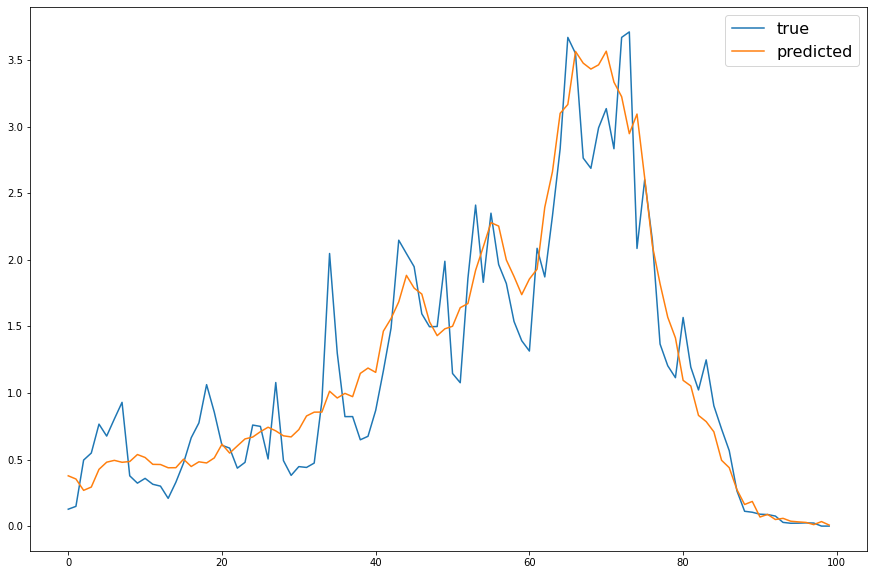

In [174]:
for example in dataset_validation.take(1):
    #print(example.shape)
    ex = example[0]
    idx = random.randint(0,32)
    img = ex[1][idx]
    seq = ex[0][idx]
    print(img.shape, seq.shape)
    #print(ex[0].shape, ex[1].shape)
    #print(ex[0].numpy().reshape(1,100,1).shape)
    plt.figure(figsize=(15,10))
    plt.plot(seq)
    plt.plot(sfr_and_images_model.predict((seq.numpy().reshape(1,100,1), img.numpy().reshape(1,128,128,4))).flatten())
    plt.legend(['true', "predicted"], fontsize=16)
    

Text(0.5, 1.0, 'Predicting from random vector')

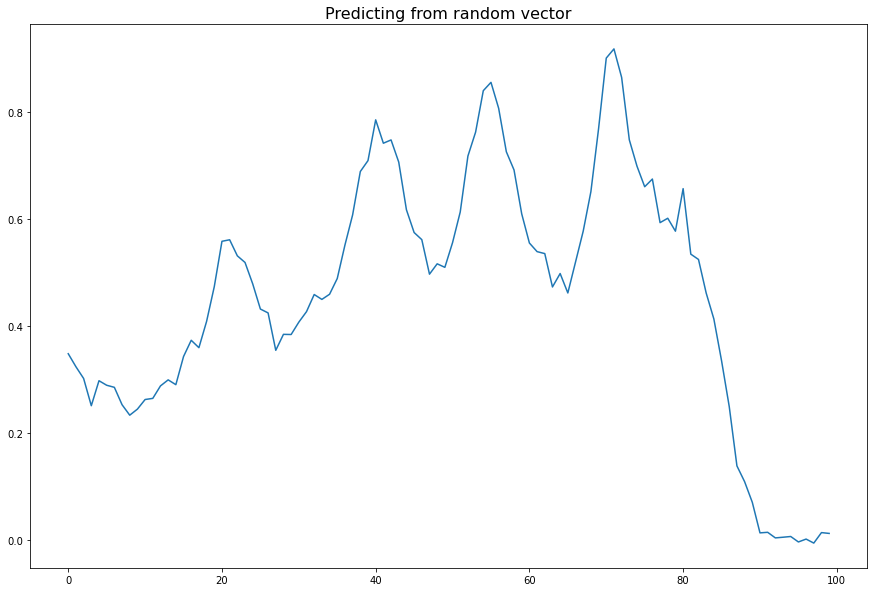

In [319]:
plt.figure(figsize=(15,10))
plt.plot(prob_decoder.predict(np.random.random((1,16,1))).flatten())
plt.title("Predicting from random vector", fontsize=16)

<TakeDataset element_spec=(TensorSpec(shape=(64, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 100, 1), dtype=tf.float32, name=None))>

### Check learning curve

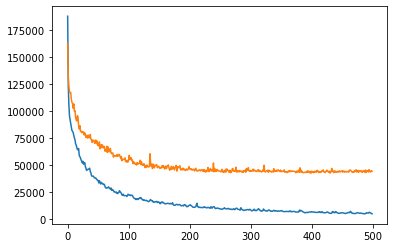

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

### Pass sample

Feed a dataset sample to the network and visualize output

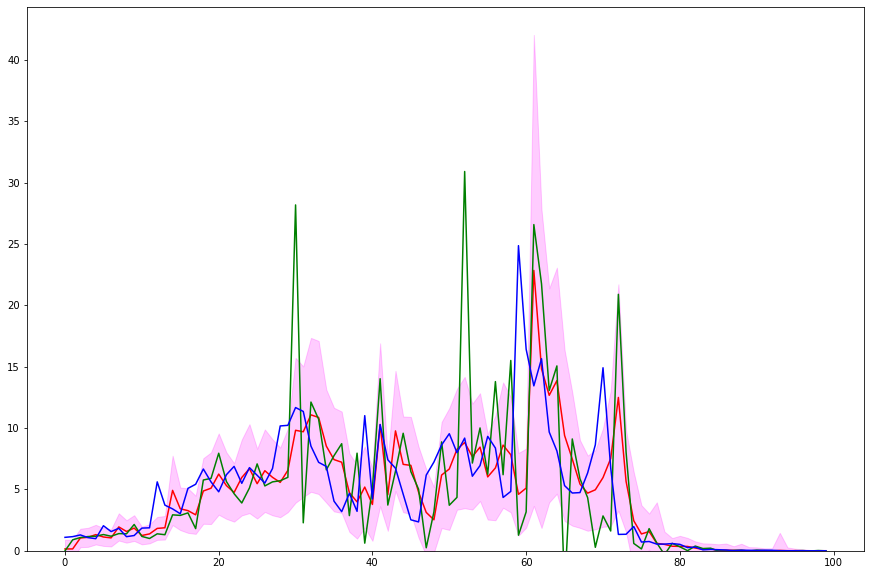

In [184]:
import random
sample = list(dset.take(100))[random.randint(3,100)]
samp_mean, samp_std, p_sample = pass_sample(pixel_cnn, sample['SFR_Max'])
plt.figure(figsize=(15,10))
std = samp_std.numpy().reshape((-1,))
mean = samp_mean.numpy().reshape((-1,))
plt.plot(mean,'r')
plt.fill_between(np.linspace(0,99,100,endpoint=True), y1=mean+std, y2=mean-std, color='magenta', alpha=0.2)
plt.plot(p_sample.numpy().reshape((-1,)), 'g')
plt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')
plt.ylim(bottom=0.0)
plt.show()

### Predictor

A randomly generated SFR from the model

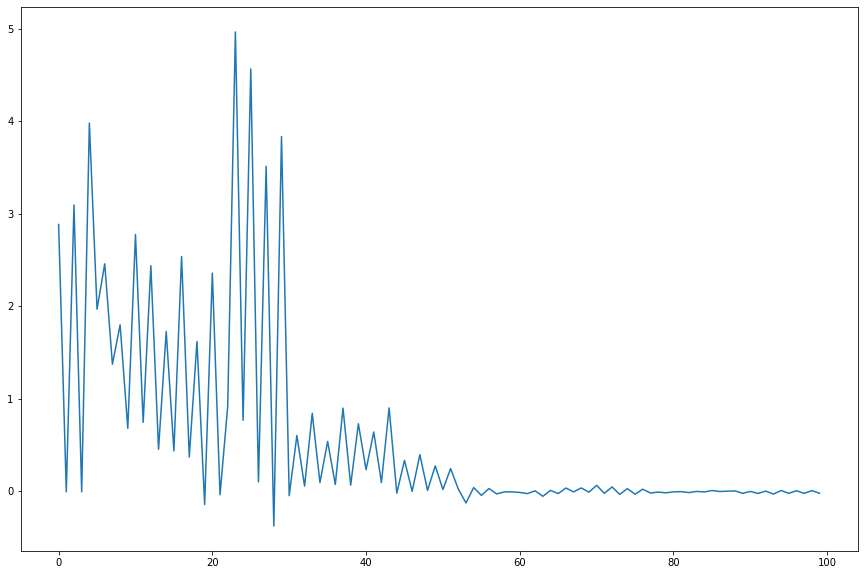

In [190]:
gen_sample = predictor(pixel_cnn, 1).reshape((-1,))
plt.figure(figsize=(15,10))
plt.plot(gen_sample)
plt.show()


### Finish sample

Take a part of a SFR sequence, and predicts the endplt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')

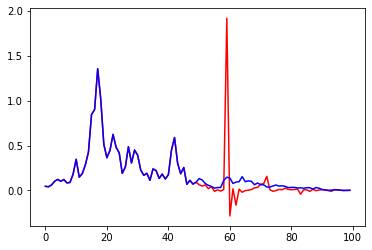

In [14]:
# TODO FIX MEEE
import importlib
import sys
sys.path.insert(0,'../sfh')
import model_utils
importlib.reload(model_utils)

gen_sample = model_utils.finish_sample(pixel_cnn, sample['SFR_Max'][:50]).reshape((-1,))
plt.plot(gen_sample, 'r')
plt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')
plt.show()


In [17]:
"""
## Build the model based on the original paper
"""

inputs = keras.Input(shape=(28,1))
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

#out = keras.layers.Conv1D(
#    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
#)(x)

out = tfp.layers.MixtureNormal(num_components, event_shape)(x)


pixel_cnn = keras.Model(inputs, out)

negloglik = lambda y, q: -q.log_prob(y)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss=negloglik)

pixel_cnn.summary()

In [52]:
from tensorflow.keras.utils import plot_model

plot_model(pixel_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2
)


In [ ]:
"""
## Demonstration
The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.
"""

from IPython.display import Image, display

# Create an empty array of pixels.
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )



In [ ]:

def deprocess_image(x):
    # Stack the single channeled black and white image to rgb values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))

In [159]:
l = 1
print(pixel_cnn.layers[l].input_shape)
print(pixel_cnn.layers[l].conv.kernel.get_shape())

(None, 100, 1)
(3, 1, 16)


[autoreload of sfh.models.pixelcnn_res failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_fr

(1, 16, 16)


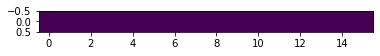

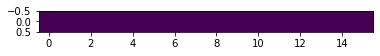

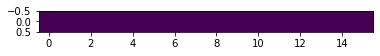

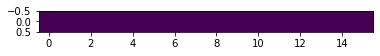

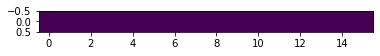

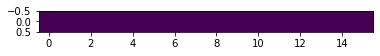

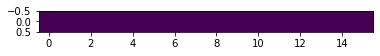

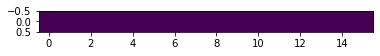

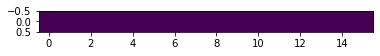

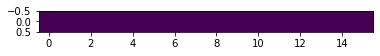

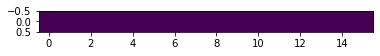

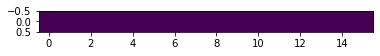

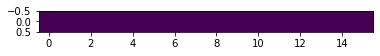

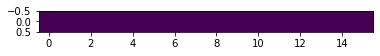

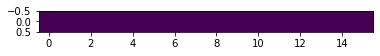

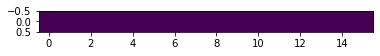

In [151]:
filt = np.ones(shape=pixel_cnn.layers[3].kernel.get_shape() )
print(filt.shape)
filt[-1,...] = 0
for i in range(16):
    plt.imshow(filt[...,i], vmin=0, vmax=1)
    plt.show()


In [ ]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

In [ ]:
for i in range(3):
    plt.imshow(filt[i], vmin=-1, vmax=1)
    plt.show()